In [28]:
import torch
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

PRINT_IMG = True
AUGMENT_DATASET = False
TRANSFORM_DATASET = False

### Hyperparameters ###
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 30

In [2]:
# Funzione per creare coppie di immagini e etichettarli con "maggiore", "minore" o "uguale"
def create_image_pairs(dataset):
    image_pairs = []
    labels = []

    for i in range(len(dataset)):
        img_A, label_A = dataset[i]

        # Seleziona un'altra immagine casuale
        idx_B = random.randint(0, len(dataset) - 1)
        img_B, label_B = dataset[idx_B]
        # Determina la relazione tra le etichette
        if label_A > label_B:
            relation_label = 0  # A > B
        elif label_A < label_B:
            relation_label = 1  # A < B
        else:
            relation_label = 2  # A = B

        # Aggiungi la coppia e la relazione
        image_pairs.append((img_A, img_B))
        labels.append(relation_label)

    return image_pairs, labels

In [3]:
# Dataset personalizzato per gestire le coppie di immagini
class MNISTPairDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.image_pairs, self.labels = create_image_pairs(dataset)

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_A, img_B = self.image_pairs[idx]
        label = self.labels[idx]

        # Concatenare le immagini lungo il canale (depth)
        concatenated_image = torch.cat((img_A, img_B), dim=0)

        return concatenated_image, label


In [4]:
# Funzione per visualizzare una coppia di immagini e la loro etichetta di relazione
def show_image_pair(img_A, img_B, relation_label):
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Converte il tensore in numpy array per visualizzazione
    img_A = img_A.squeeze().numpy()  # Rimuove la dimensione del canale
    img_B = img_B.squeeze().numpy()

    # Crea una figura con due immagini, riducendo la dimensione per occupare meno spazio
    fig, axes = plt.subplots(1, 2, figsize=(4, 4))  # Dimensioni ridotte

    # Mostra le immagini
    axes[0].imshow(img_A, cmap='gray')
    axes[0].set_title('Image A')
    axes[0].axis('off')  # Rimuove gli assi

    axes[1].imshow(img_B, cmap='gray')
    axes[1].set_title('Image B')
    axes[1].axis('off')  # Rimuove gli assi

    # Riduce lo spazio tra i subplots
    plt.tight_layout(pad=0.5)  # Riduce il padding tra le immagini

    # Mostra il titolo della relazione
    plt.suptitle(f'Relation: {relation_labels[relation_label]}', y=0.85)  # Posiziona il titolo più vicino
    plt.show()


In [5]:
# Funzione per visualizzare più coppie di immagini in un'unica figura
def show_dataset(dataset, num_images=5):
    dataiter = iter(dataset)
    images, labels = next(dataiter)

    # Mappa delle etichette di relazione
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}

    # Numero di righe: ogni riga contiene 1 coppia di immagini (2 colonne)
    num_rows = num_images  # 1 coppia per riga

    # Crea una griglia di subplots: num_rows righe, 3 colonne (Image A, Relation, Image B)
    fig, axes = plt.subplots(num_rows, 3, figsize=(6, num_rows * 2))
    
    for i in range(num_images):
        concatenated_image = images[i]
        label = labels[i].item()

        img_A = concatenated_image[0, :, :]
        img_B = concatenated_image[1, :, :]

        # Mostra l'immagine A nel subplot
        axes[i, 0].imshow(img_A, cmap='gray')
        axes[i, 0].set_title('Image A')
        axes[i, 0].axis('off')

        # Mostra l'etichetta di relazione nel subplot centrale
        axes[i, 1].text(0.5, 0.5, f'Relation: {relation_labels[label]}', 
                        fontsize=12, ha='center', va='center')
        axes[i, 1].axis('off')

        # Mostra l'immagine B nel subplot
        axes[i, 2].imshow(img_B, cmap='gray')
        axes[i, 2].set_title('Image B')
        axes[i, 2].axis('off')  # Nascondi gli assi

    # Applica il layout compatto per ridurre lo spazio tra i subplot
    plt.tight_layout(pad=0.5)
    plt.show()


In [6]:
# Definisci la funzione per aggiungere rumore gaussiano
def add_gaussian_noise(tensor, mean=0.0, std=0.05):
    return tensor + std * torch.randn_like(tensor) + mean

In [7]:
# Definisci la funzione per invertire i colori
def invert_colors(tensor):
    return 1 - tensor

In [8]:
# Trasformo le immagini in tensori e normalizzo i valori secondo le statiche del dataset MNIST
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

# Applico data augmentation sul dataset di training
transform_augmented = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.RandomChoice([
        transforms.Lambda(lambda x: add_gaussian_noise(x)),
        transforms.Lambda(lambda x: invert_colors(x)),
        transforms.Lambda(lambda x: x),
    ]),
    transforms.Normalize((0.1307,), (0.3081,))
])

if not TRANSFORM_DATASET and not AUGMENT_DATASET:
    train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transform_norm)

    train_pair_dataset = MNISTPairDataset(train_dataset)

    print(f"Dimensione del dataset originale: {len(train_pair_dataset)}")

if TRANSFORM_DATASET:
    train_dataset_transformed = datasets.MNIST(root='./data', train=True, download=True,
                                                transform=transform_augmented)
    
    train_pair_dataset = MNISTPairDataset(train_dataset_transformed)
    print(f"Dimensione del dataset trasformato: {len(train_pair_dataset)}")

if AUGMENT_DATASET:
    train_dataset_augmented = datasets.MNIST(root='./data', train=True, download=True,
                                                transform=transform_augmented)
    train_pair_dataset_augmented = MNISTPairDataset(train_dataset_augmented)
    train_pair_dataset = torch.utils.data.ConcatDataset([train_pair_dataset, train_pair_dataset_augmented])

    print(f"Dimensione del dataset aumentato: {len(train_pair_dataset_augmented)}")
    print(f"Dimensione del dataset combinato: {len(train_pair_dataset)}")



Dimensione del dataset originale: 60000


In [15]:
train_loader = torch.utils.data.DataLoader(
                            train_pair_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [10]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_norm)

test_pair_dataset = MNISTPairDataset(test_dataset)
test_loader = torch.utils.data.DataLoader(test_pair_dataset, batch_size=BATCH_SIZE, shuffle=False)

total_test_size = len(test_dataset)

# Percentuale di suddivisione per il validation set 70% train, 30% validation   
validation_split = 0.3
validation_size = int(total_test_size * validation_split)
test_size = total_test_size - validation_size

# Suddividi il dataset di test
test_subset, validation_subset = torch.utils.data.random_split(test_pair_dataset, [test_size, validation_size])

In [16]:
# Crea i DataLoader per il test set e il validation set
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_subset, batch_size=BATCH_SIZE, shuffle=False)


In [17]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_pair_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_subset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_subset))

Size train_loader:  938  Size train_dataset:  60000
Size validation_loader:  47  Size validation_dataset:  3000
Size test_loader:  110  Size test_dataset:  7000


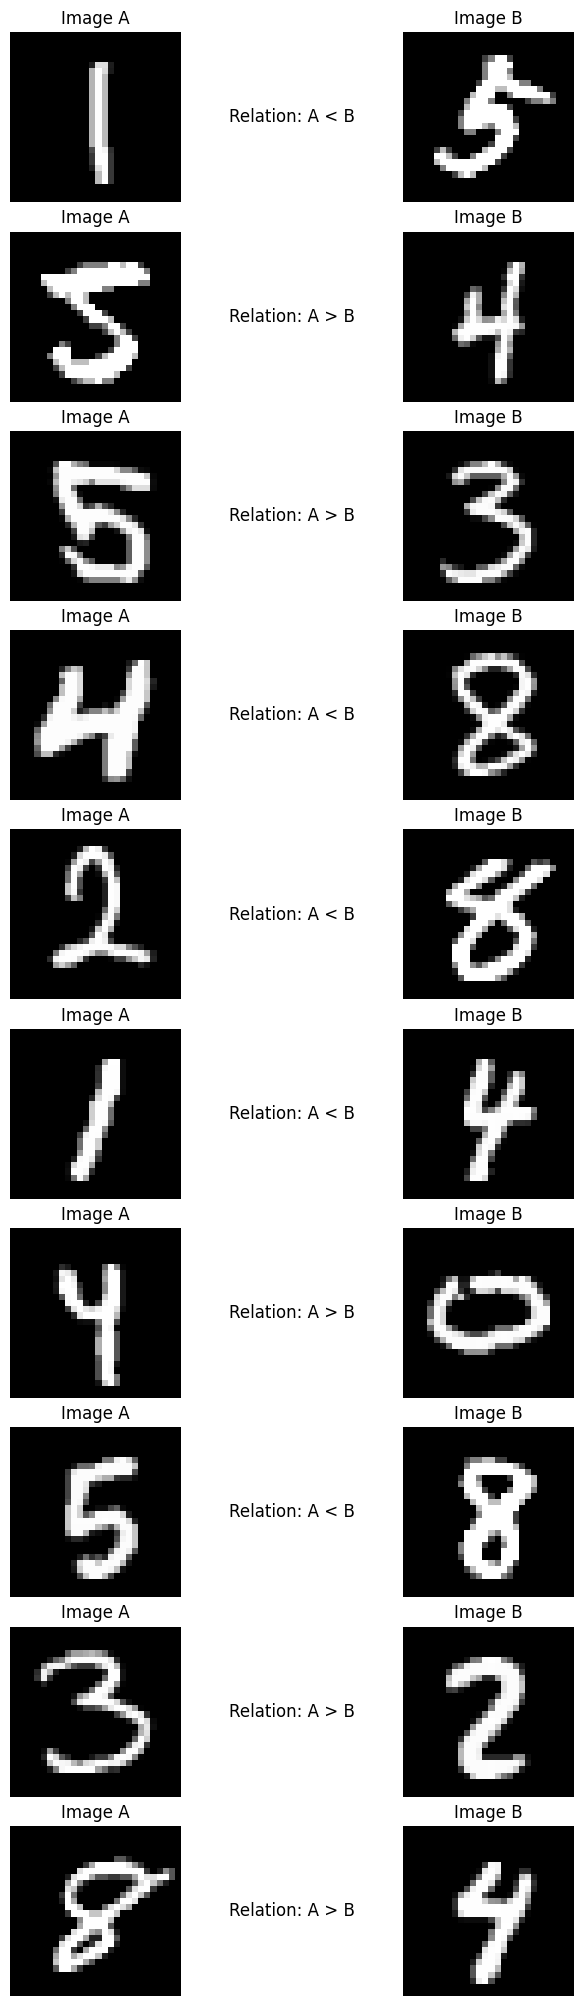

In [18]:
if PRINT_IMG:
    show_dataset(train_loader, 10)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [21]:
import torch.nn as nn
import torch.nn.functional as F

class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [22]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

In [23]:
# define train and test functions
from tqdm import tqdm

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(valid_data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [24]:
# TRAIN!!!
import time
model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        # start timer and carry out training and validation
        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(test_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)
        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")


EPOCH 1 of 30
Training


Loss: 0.7385: 100%|██████████| 938/938 [00:13<00:00, 71.80it/s]


Validating


Loss: 0.8975: 100%|██████████| 110/110 [00:00<00:00, 143.15it/s]


Epoch #1 train loss: 0.857 train accuracy: 62.45
Epoch #1 validation loss: 0.897 validation accuracy: 72.84
Took 0.231 minutes for epoch 1

EPOCH 2 of 30
Training


Loss: 0.6550: 100%|██████████| 938/938 [00:13<00:00, 71.09it/s]


Validating


Loss: 0.8638: 100%|██████████| 110/110 [00:00<00:00, 141.34it/s]


Epoch #2 train loss: 0.634 train accuracy: 74.85
Epoch #2 validation loss: 0.864 validation accuracy: 76.69
Took 0.233 minutes for epoch 2

EPOCH 3 of 30
Training


Loss: 0.5118: 100%|██████████| 938/938 [00:12<00:00, 75.40it/s]


Validating


Loss: 0.8397: 100%|██████████| 110/110 [00:00<00:00, 134.19it/s]


Epoch #3 train loss: 0.553 train accuracy: 77.93
Epoch #3 validation loss: 0.840 validation accuracy: 78.84
Took 0.221 minutes for epoch 3

EPOCH 4 of 30
Training


Loss: 0.4331: 100%|██████████| 938/938 [00:12<00:00, 73.19it/s]


Validating


Loss: 0.6583: 100%|██████████| 110/110 [00:00<00:00, 130.91it/s]


Epoch #4 train loss: 0.490 train accuracy: 80.85
Epoch #4 validation loss: 0.658 validation accuracy: 82.56
Took 0.228 minutes for epoch 4

EPOCH 5 of 30
Training


Loss: 0.3412: 100%|██████████| 938/938 [00:12<00:00, 74.34it/s]


Validating


Loss: 0.5773: 100%|██████████| 110/110 [00:00<00:00, 149.00it/s]


Epoch #5 train loss: 0.439 train accuracy: 83.11
Epoch #5 validation loss: 0.577 validation accuracy: 84.06
Took 0.223 minutes for epoch 5

EPOCH 6 of 30
Training


Loss: 0.4005: 100%|██████████| 938/938 [00:12<00:00, 74.99it/s]


Validating


Loss: 0.5321: 100%|██████████| 110/110 [00:00<00:00, 148.61it/s]


Epoch #6 train loss: 0.395 train accuracy: 85.02
Epoch #6 validation loss: 0.532 validation accuracy: 85.83
Took 0.221 minutes for epoch 6

EPOCH 7 of 30
Training


Loss: 0.6051: 100%|██████████| 938/938 [00:12<00:00, 74.42it/s]


Validating


Loss: 0.4995: 100%|██████████| 110/110 [00:00<00:00, 141.37it/s]


Epoch #7 train loss: 0.352 train accuracy: 86.71
Epoch #7 validation loss: 0.500 validation accuracy: 86.89
Took 0.223 minutes for epoch 7

EPOCH 8 of 30
Training


Loss: 0.2088: 100%|██████████| 938/938 [00:12<00:00, 75.52it/s]


Validating


Loss: 0.4939: 100%|██████████| 110/110 [00:00<00:00, 136.15it/s]


Epoch #8 train loss: 0.319 train accuracy: 88.13
Epoch #8 validation loss: 0.494 validation accuracy: 87.96
Took 0.221 minutes for epoch 8

EPOCH 9 of 30
Training


Loss: 0.2811: 100%|██████████| 938/938 [00:12<00:00, 74.93it/s]


Validating


Loss: 0.3524: 100%|██████████| 110/110 [00:00<00:00, 147.99it/s]


Epoch #9 train loss: 0.289 train accuracy: 89.30
Epoch #9 validation loss: 0.352 validation accuracy: 88.27
Took 0.221 minutes for epoch 9

EPOCH 10 of 30
Training


Loss: 0.2022: 100%|██████████| 938/938 [00:12<00:00, 74.50it/s]


Validating


Loss: 0.3440: 100%|██████████| 110/110 [00:00<00:00, 154.25it/s]


Epoch #10 train loss: 0.264 train accuracy: 90.24
Epoch #10 validation loss: 0.344 validation accuracy: 89.67
Took 0.222 minutes for epoch 10

EPOCH 11 of 30
Training


Loss: 0.2363: 100%|██████████| 938/938 [00:12<00:00, 74.82it/s]


Validating


Loss: 0.4651: 100%|██████████| 110/110 [00:00<00:00, 148.48it/s]


Epoch #11 train loss: 0.239 train accuracy: 91.19
Epoch #11 validation loss: 0.465 validation accuracy: 90.19
Took 0.221 minutes for epoch 11

EPOCH 12 of 30
Training


Loss: 0.1099: 100%|██████████| 938/938 [00:12<00:00, 73.96it/s]


Validating


Loss: 0.2737: 100%|██████████| 110/110 [00:00<00:00, 133.05it/s]


Epoch #12 train loss: 0.222 train accuracy: 91.92
Epoch #12 validation loss: 0.274 validation accuracy: 91.20
Took 0.225 minutes for epoch 12

EPOCH 13 of 30
Training


Loss: 0.1382: 100%|██████████| 938/938 [00:13<00:00, 69.01it/s]


Validating


Loss: 0.4637: 100%|██████████| 110/110 [00:00<00:00, 130.50it/s]


Epoch #13 train loss: 0.204 train accuracy: 92.50
Epoch #13 validation loss: 0.464 validation accuracy: 90.57
Took 0.241 minutes for epoch 13

EPOCH 14 of 30
Training


Loss: 0.2792: 100%|██████████| 938/938 [00:13<00:00, 70.11it/s]


Validating


Loss: 0.3235: 100%|██████████| 110/110 [00:00<00:00, 145.59it/s]


Epoch #14 train loss: 0.191 train accuracy: 93.05
Epoch #14 validation loss: 0.324 validation accuracy: 92.00
Took 0.236 minutes for epoch 14

EPOCH 15 of 30
Training


Loss: 0.1071: 100%|██████████| 938/938 [00:12<00:00, 75.05it/s]


Validating


Loss: 0.3790: 100%|██████████| 110/110 [00:00<00:00, 149.48it/s]


Epoch #15 train loss: 0.178 train accuracy: 93.57
Epoch #15 validation loss: 0.379 validation accuracy: 92.39
Took 0.221 minutes for epoch 15

EPOCH 16 of 30
Training


Loss: 0.0610: 100%|██████████| 938/938 [00:12<00:00, 77.32it/s]


Validating


Loss: 0.3737: 100%|██████████| 110/110 [00:00<00:00, 137.77it/s]


Epoch #16 train loss: 0.165 train accuracy: 94.04
Epoch #16 validation loss: 0.374 validation accuracy: 92.56
Took 0.216 minutes for epoch 16

EPOCH 17 of 30
Training


Loss: 0.1012: 100%|██████████| 938/938 [00:12<00:00, 76.94it/s]


Validating


Loss: 0.2739: 100%|██████████| 110/110 [00:00<00:00, 155.63it/s]


Epoch #17 train loss: 0.154 train accuracy: 94.42
Epoch #17 validation loss: 0.274 validation accuracy: 92.37
Took 0.215 minutes for epoch 17

EPOCH 18 of 30
Training


Loss: 0.1244: 100%|██████████| 938/938 [00:11<00:00, 78.64it/s]


Validating


Loss: 0.2960: 100%|██████████| 110/110 [00:00<00:00, 139.84it/s]


Epoch #18 train loss: 0.145 train accuracy: 94.79
Epoch #18 validation loss: 0.296 validation accuracy: 92.93
Took 0.212 minutes for epoch 18

EPOCH 19 of 30
Training


Loss: 0.0941: 100%|██████████| 938/938 [00:12<00:00, 76.13it/s]


Validating


Loss: 0.3013: 100%|██████████| 110/110 [00:00<00:00, 153.83it/s]


Epoch #19 train loss: 0.135 train accuracy: 95.13
Epoch #19 validation loss: 0.301 validation accuracy: 92.97
Took 0.217 minutes for epoch 19

EPOCH 20 of 30
Training


Loss: 0.0435: 100%|██████████| 938/938 [00:12<00:00, 77.73it/s]


Validating


Loss: 0.4088: 100%|██████████| 110/110 [00:00<00:00, 138.03it/s]


Epoch #20 train loss: 0.128 train accuracy: 95.40
Epoch #20 validation loss: 0.409 validation accuracy: 92.93
Took 0.215 minutes for epoch 20

EPOCH 21 of 30
Training


Loss: 0.0614: 100%|██████████| 938/938 [00:12<00:00, 78.00it/s]


Validating


Loss: 0.3436: 100%|██████████| 110/110 [00:00<00:00, 154.43it/s]


Epoch #21 train loss: 0.120 train accuracy: 95.68
Epoch #21 validation loss: 0.344 validation accuracy: 93.66
Took 0.212 minutes for epoch 21

EPOCH 22 of 30
Training


Loss: 0.0378: 100%|██████████| 938/938 [00:12<00:00, 75.00it/s]


Validating


Loss: 0.3629: 100%|██████████| 110/110 [00:00<00:00, 158.22it/s]


Epoch #22 train loss: 0.114 train accuracy: 95.89
Epoch #22 validation loss: 0.363 validation accuracy: 93.76
Took 0.220 minutes for epoch 22

EPOCH 23 of 30
Training


Loss: 0.0504: 100%|██████████| 938/938 [00:11<00:00, 78.37it/s]


Validating


Loss: 0.3668: 100%|██████████| 110/110 [00:00<00:00, 138.53it/s]


Epoch #23 train loss: 0.108 train accuracy: 96.10
Epoch #23 validation loss: 0.367 validation accuracy: 93.50
Took 0.213 minutes for epoch 23

EPOCH 24 of 30
Training


Loss: 0.0920: 100%|██████████| 938/938 [00:11<00:00, 78.28it/s]


Validating


Loss: 0.3127: 100%|██████████| 110/110 [00:00<00:00, 152.00it/s]


Epoch #24 train loss: 0.101 train accuracy: 96.53
Epoch #24 validation loss: 0.313 validation accuracy: 93.81
Took 0.212 minutes for epoch 24

EPOCH 25 of 30
Training


Loss: 0.0925: 100%|██████████| 938/938 [00:12<00:00, 77.97it/s]


Validating


Loss: 0.2651: 100%|██████████| 110/110 [00:00<00:00, 137.01it/s]


Epoch #25 train loss: 0.096 train accuracy: 96.61
Epoch #25 validation loss: 0.265 validation accuracy: 93.77
Took 0.214 minutes for epoch 25

EPOCH 26 of 30
Training


Loss: 0.0815: 100%|██████████| 938/938 [00:12<00:00, 77.09it/s]


Validating


Loss: 0.4155: 100%|██████████| 110/110 [00:00<00:00, 138.12it/s]


Epoch #26 train loss: 0.091 train accuracy: 96.72
Epoch #26 validation loss: 0.416 validation accuracy: 93.73
Took 0.216 minutes for epoch 26

EPOCH 27 of 30
Training


Loss: 0.0623: 100%|██████████| 938/938 [00:12<00:00, 75.63it/s]


Validating


Loss: 0.2999: 100%|██████████| 110/110 [00:00<00:00, 150.60it/s]


Epoch #27 train loss: 0.086 train accuracy: 96.94
Epoch #27 validation loss: 0.300 validation accuracy: 93.60
Took 0.219 minutes for epoch 27

EPOCH 28 of 30
Training


Loss: 0.0633: 100%|██████████| 938/938 [00:12<00:00, 76.27it/s]


Validating


Loss: 0.2206: 100%|██████████| 110/110 [00:00<00:00, 132.90it/s]


Epoch #28 train loss: 0.081 train accuracy: 97.12
Epoch #28 validation loss: 0.221 validation accuracy: 94.00
Took 0.219 minutes for epoch 28

EPOCH 29 of 30
Training


Loss: 0.0332: 100%|██████████| 938/938 [00:12<00:00, 76.24it/s]


Validating


Loss: 0.3308: 100%|██████████| 110/110 [00:00<00:00, 157.65it/s]


Epoch #29 train loss: 0.079 train accuracy: 97.25
Epoch #29 validation loss: 0.331 validation accuracy: 94.13
Took 0.217 minutes for epoch 29

EPOCH 30 of 30
Training


Loss: 0.0346: 100%|██████████| 938/938 [00:12<00:00, 76.21it/s]


Validating


Loss: 0.2616: 100%|██████████| 110/110 [00:00<00:00, 152.27it/s]

Epoch #30 train loss: 0.071 train accuracy: 97.50
Epoch #30 validation loss: 0.262 validation accuracy: 93.89
Took 0.217 minutes for epoch 30


204 previsioni errate trovate.


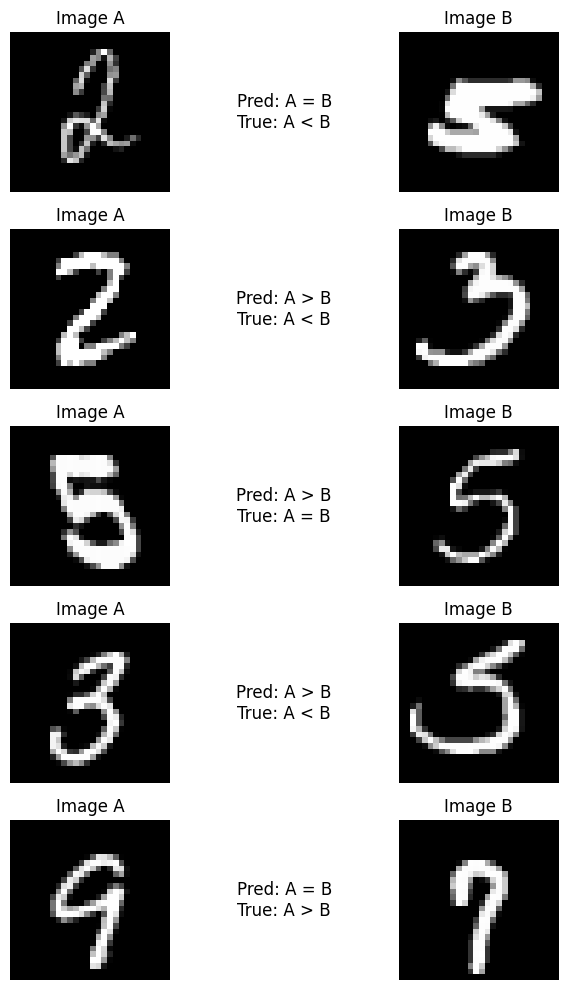

In [35]:
def show_incorrect_predictions(model, dataloader, num_images=5):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    # Itera su tutti i batch nel dataloader
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            
            all_images.append(images.cpu())
            all_labels.append(labels.cpu())
            all_preds.append(predicted.cpu())

    # Concatena tutti i batch raccolti
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)

    # Trova gli indici delle previsioni errate
    incorrect_predictions = (all_preds != all_labels).nonzero(as_tuple=True)[0]

    print(f"{len(incorrect_predictions)} previsioni errate trovate.")

    if len(incorrect_predictions) == 0:
        print("Nessuna previsione errata trovata.")
        return

    # Limita il numero di immagini errate da mostrare
    num_images = min(num_images, len(incorrect_predictions))

    fig, axes = plt.subplots(num_images, 3, figsize=(6, num_images * 2))
    relation_labels = {0: 'A > B', 1: 'A < B', 2: 'A = B'}
    
    for idx, i in enumerate(incorrect_predictions[:num_images]):
        img_A = all_images[i][0, :, :]
        img_B = all_images[i][1, :, :]
        pred_label = all_preds[i].item()
        true_label = all_labels[i].item()

        # Mostra l'immagine A
        axes[idx, 0].imshow(img_A, cmap='gray')
        axes[idx, 0].set_title('Image A')
        axes[idx, 0].axis('off')

        # Mostra l'etichetta di relazione prevista e reale
        axes[idx, 1].text(0.5, 0.5, f'Pred: {relation_labels[pred_label]}\nTrue: {relation_labels[true_label]}', 
                          fontsize=12, ha='center', va='center')
        axes[idx, 1].axis('off')

        # Mostra l'immagine B
        axes[idx, 2].imshow(img_B, cmap='gray')
        axes[idx, 2].set_title('Image B')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizza alcune previsioni errate
show_incorrect_predictions(model, validation_loader, num_images=5)


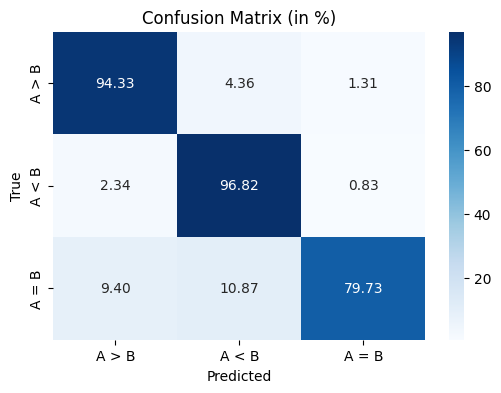

In [29]:
# Funzione per calcolare e stampare la matrice di confusione normalizzata
def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Crea la matrice di confusione
    cm = confusion_matrix(all_labels, all_preds)
    
    # Normalizza la matrice di confusione
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizza per ogni riga (classe vera)
    
    # Visualizza la matrice di confusione normalizzata in percentuale
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", cmap="Blues", 
                xticklabels=['A > B', 'A < B', 'A = B'], 
                yticklabels=['A > B', 'A < B', 'A = B'])
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (in %)')
    plt.show()

# Calcola e visualizza la matrice di confusione
plot_confusion_matrix(model, test_loader, device)


In [100]:
def classification_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    # Disabilita i gradienti per velocizzare il calcolo
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Genera il report di classificazione
    report = classification_report(all_labels, all_preds, target_names=['A > B', 'A < B', 'A = B'])
    print(report)

# Stampa il report delle metriche
classification_metrics(model, test_loader, device)


              precision    recall  f1-score   support

       A > B       0.87      0.88      0.87      3184
       A < B       0.83      0.91      0.87      3111
       A = B       0.77      0.42      0.54       705

    accuracy                           0.85      7000
   macro avg       0.82      0.73      0.76      7000
weighted avg       0.84      0.85      0.84      7000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

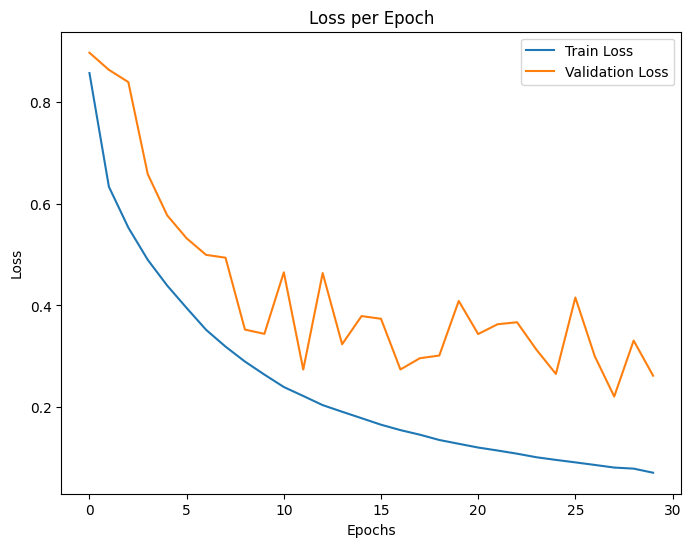

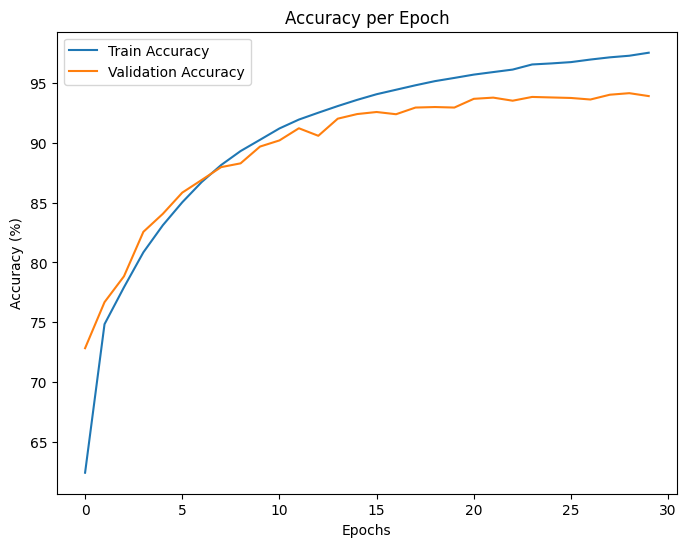

In [36]:
# Plot della loss per epoca
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

# Plot dell'accuratezza per epoca
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()
